<a href="https://colab.research.google.com/github/mz-zarei/TimeSeriesAnalysis/blob/main/PedestrianFlowForecasting/PedCrossVolumeModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Imports

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from IPython.display import display
import os

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.1f}'.format
%matplotlib inline

# 1. Read Data

In [4]:
# Read the data
path_to_data = './data/20180525-20200416-Milton-Ped-Volume-Per-Crosswalk.csv'
df_all = pd.read_csv(path_to_data, delimiter=';')
## Combine date/time columns and change the type to datetime 
df_all['date'] = pd.to_datetime(df_all['date'] + ' ' + df_all['time'], format='%Y-%m-%d %H:%M:%S')
## Set index as date column and sort
df_all.set_index('date', inplace=True)
df_all.sort_index(inplace=True)
## Drop unused columns
df_all.drop(columns=['latitude', 'longitude', 'time', 'vol_vehicle'], inplace=True)

# Show the date range
print(f'Data From {df_all.index.min()} to {df_all.index.max()}')
# Show first 10 rows
display(df_all.head())
# Show unique intersections names
print(df_all.name.unique())

Data From 2018-05-25 15:00:00 to 2020-04-16 23:45:00


,id,name,ped_N,ped_S,ped_E,ped_W
date,,,,,,
2018-05-25 15:00:00,af48a872-12a8-4142-be64-8f6cf84e58f9,Thompson Road and McCuaig Drive,0,0,0,0
2018-05-25 15:15:00,af48a872-12a8-4142-be64-8f6cf84e58f9,Thompson Road and McCuaig Drive,0,0,0,0
2018-05-25 15:30:00,af48a872-12a8-4142-be64-8f6cf84e58f9,Thompson Road and McCuaig Drive,0,0,0,0
2018-05-25 15:45:00,af48a872-12a8-4142-be64-8f6cf84e58f9,Thompson Road and McCuaig Drive,0,0,0,0
2018-05-25 16:00:00,af48a872-12a8-4142-be64-8f6cf84e58f9,Thompson Road and McCuaig Drive,0,0,0,0


['Thompson Road and McCuaig Drive' 'Thompson Road and Nipissing Road'
 'James Snow Parkway and Derry Road' 'Thompson Road and Laurier Avenue'
 'Thompson Road and Main Street' 'Ontario Street South and Childs Drive'
 'Ontario Street South and Pine Street'
 'Main Street East and Ontario Street North'
 'Main Street East and Mall Entrance'
 'Bronte Street North and Main Street West'
 'Martin Street and Main Street East' 'Main Street and Sherwood'
 'Laurier Avenue and Ontario Street South'
 'Louis St Laurent Avenue and Commercial Plaza'
 'Thompson Road and Drew Centre'
 'Louis St Laurent Avenue and Farmstead Drive'
 'Main Street E and Harris / Pearson'
 'Main Street East and Leisure Centre Driveway'
 'Main Street East and Maple / Sinclair' 'Fifth Line and Yukon Court'
 'Thompson Road North and Maple Avenue'
 'Thompson Road North and Woodward Avenue'
 'Steeles Avenue East and Martin Street'
 'Main Street West and Scott Boulevard']


# 3. EDA

In [72]:
# Choose one/more intersection
df = df_all[df_all['name'] == 'Thompson Road and Laurier Avenue']
# drop data after 2019-01-01
df = df[(df.index > "2019-01-01") & (df.index < "2020-01-01")]
# Summary statistics
df.describe()

,ped_N,ped_S,ped_E,ped_W
count,"34,369.0","34,369.0","34,369.0","34,369.0"
mean,0.5,0.4,0.8,0.8
std,1.1,0.8,1.3,1.4
min,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0
75%,1.0,0.0,1.0,1.0
max,56.0,10.0,53.0,16.0


In [73]:
# Check if there is any Null target values
print('Number of null values (ped_N): {0}'.format(df.ped_N.isnull().sum()))
print('Number of null values (ped_S): {0}'.format(df.ped_S.isnull().sum()))
print('Number of null values (ped_E): {0}'.format(df.ped_E.isnull().sum()))
print('Number of null values (ped_W): {0}'.format(df.ped_W.isnull().sum()))

Number of null values (ped_N): 0
Number of null values (ped_S): 0
Number of null values (ped_E): 0
Number of null values (ped_W): 0


In [74]:
# Resample data to get daily or weekly or monthly counts
aggregation = 'D'
df_r = df.resample(aggregation).sum()

# Check for duplicate index values
print('Duplicate dates in our data (before): ', df_r.index.duplicated().sum())

# Summary statistics
df_r.describe()

Duplicate dates in our data (before):  0


,ped_N,ped_S,ped_E,ped_W
count,365.0,365.0,365.0,365.0
mean,45.2,33.1,72.1,72.8
std,26.3,16.2,33.9,45.3
min,0.0,0.0,0.0,0.0
25%,25.0,20.0,45.0,37.0
50%,40.0,32.0,69.0,69.0
75%,62.0,45.0,95.0,99.0
max,164.0,87.0,172.0,217.0


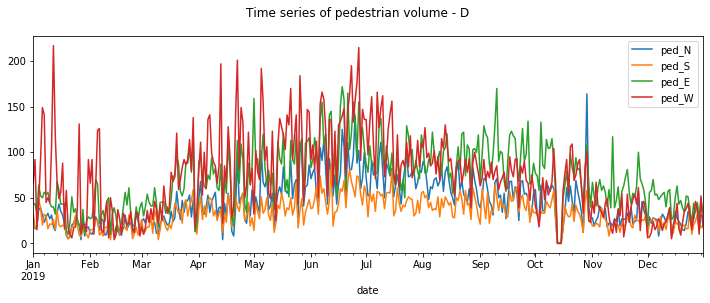

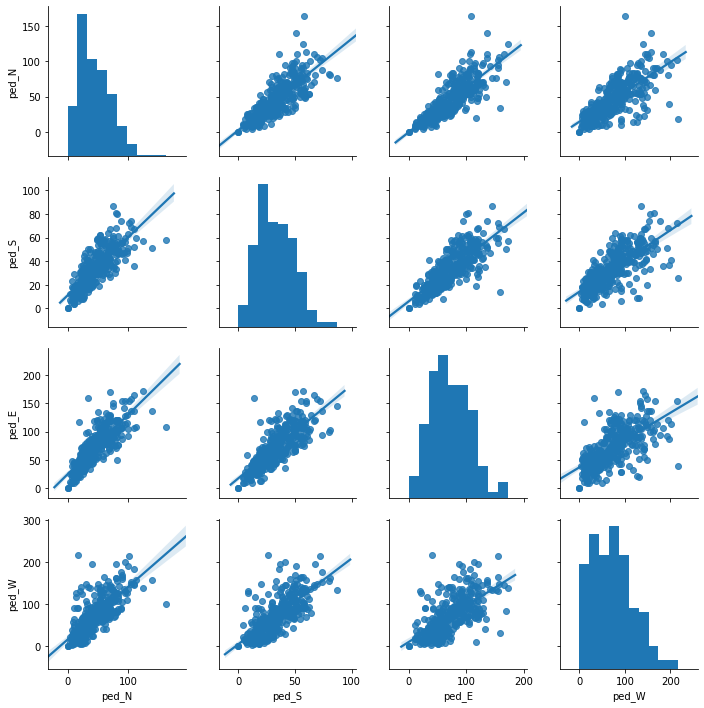

In [75]:
# Plotting the time series of Ped counts for each crossing
fig, axs = plt.subplots(1, figsize=(12, 4))
fig.suptitle('Time series of pedestrian volume - ' + aggregation)

df_r.ped_N.plot(ax=axs)
df_r.ped_S.plot(ax=axs)
df_r.ped_E.plot(ax=axs)
df_r.ped_W.plot(ax=axs)
axs.legend()
plt.show()

# Distributions and scatter pair plots
sns.pairplot(df_r, kind='reg')

# 4. Compute true volume ratio for each approach

In [76]:
# average annual daily pedestrian traffic
AADPT = (df.ped_N.sum()+df.ped_S.sum()+df.ped_W.sum()+df.ped_E.sum())

ratio_N_true = df.ped_N.sum() / AADPT
ratio_S_true = df.ped_S.sum() / AADPT
ratio_W_true = df.ped_W.sum() / AADPT
ratio_E_true = df.ped_E.sum() / AADPT

print(f'AADPT: {AADPT}')
print(f'True Ratio N:{ratio_N_true:.{2}f}, S:{ratio_S_true:.{2}f}')
print(f'           W:{ratio_W_true:.{2}f}, E:{ratio_E_true:.{2}f}')

AADPT: 81482
True Ratio N:0.20, S:0.15
           W:0.33, E:0.32


# 5. Calculate short-term counts for each approach

In [77]:
# Resample data to get Hourly counts
df_h = df.resample('H').sum()

# Keep valid hours for short-term count 7am-9am, 11am-2pm, 3pm-6pm
df_h_valid = pd.concat([df_h.between_time('7:00', '9:00'),
                        df_h.between_time('11:00', '14:00'),
                        df_h.between_time('15:00', '18:00')])
print('Hours: ', df_h_valid.index.hour.unique())

# Resample data to get daily shour-term counts
df_d = df_h_valid.resample('D').sum()

# Keep valid day of weeks Tuesdays (1), Wednesdays (2), and Thursdays (3)
df_d_valid = df_d[df_d.index.dayofweek.isin([1,2,3])]
print('Day of Weeks: ', df_d_valid.index.day_of_week.unique())

# Exclude the holidays
holidays = ['2019-01-01','2019-01-02', '2019-01-03', '2019-01-20',
            '2019-02-17', 
            '2019-03-16', '2019-03-17', '2019-03-18', '2019-03-19', '2019-03-20']
df_d_valid = df_d_valid[~df_d_valid.index.isin(holidays)]


Hours:  Int64Index([7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18], dtype='int64', name='date')
Day of Weeks:  Int64Index([1, 2, 3], dtype='int64', name='date')


# 6. Calculate volume ratio error from ST counts

95% CI: (-0.4102091697696465, 0.4906354555849174)


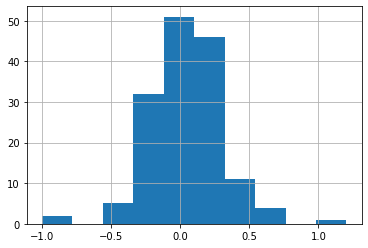

95% CI: (-0.5057293793005386, 0.41744094575016005)


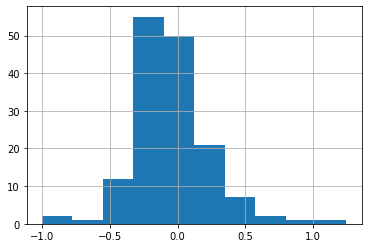

95% CI: (-0.6308119586567303, 0.42180021135448126)


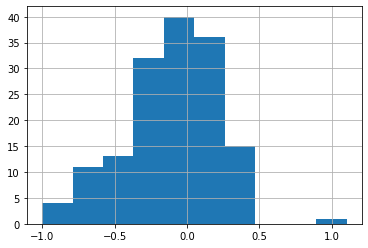

95% CI: (-0.4432045018110493, 0.6029778970820101)


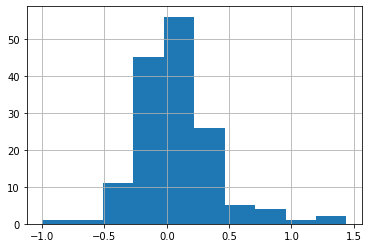

In [116]:
df_d_valid['total'] = df_d_valid.ped_N + df_d_valid.ped_S + df_d_valid.ped_W + df_d_valid.ped_E + 0.01

df_d_valid['ratio_N'] = df_d_valid.ped_N / df_d_valid.total
df_d_valid['ratio_S'] = df_d_valid.ped_S / df_d_valid.total
df_d_valid['ratio_W'] = df_d_valid.ped_W / df_d_valid.total
df_d_valid['ratio_E'] = df_d_valid.ped_E / df_d_valid.total

df_d_valid['ratio_N_err'] = (df_d_valid.ped_N / df_d_valid.total - ratio_N_true)/ratio_N_true
df_d_valid['ratio_S_err'] = (df_d_valid.ped_S / df_d_valid.total - ratio_S_true)/ratio_S_true
df_d_valid['ratio_W_err'] = (df_d_valid.ped_W / df_d_valid.total - ratio_W_true)/ratio_W_true
df_d_valid['ratio_E_err'] = (df_d_valid.ped_E / df_d_valid.total - ratio_E_true)/ratio_E_true



def confidence_interval(df, col):
    '''
    returns lower and upper bound of 95% CI for given column assuming normal dist
    '''
    mean = df[col].mean()
    sd = df[col].std()
    n = len(df)
    Zstar=1.65

    lcb = mean - Zstar * sd
    ucb = mean + Zstar * sd
    return lcb, ucb
    
# Plot the dist of the errors and 95% CI
for col in ['ratio_N_err','ratio_S_err','ratio_W_err','ratio_E_err']:
    df_d_valid[col].hist()
    print(f'95% CI: {confidence_interval(df_d_valid, col)}')
    plt.show()